In [45]:
import sys
sys.path.append('../')
import importlib
import numpy as np
import model.op
importlib.reload(model.op)
from model.op import number_aircrafts_lp

## Default parameters in LP

- Timestep: 5 min

- Flight time tau: 2 timesteps

- Kappa: 10% charge, 2 levels of SOC

- Gamma: 16 SOCs


In [46]:
gamma = np.array([
0.0129,0.0133,0.0137,0.0142,0.0147,
0.0153,0.0158,0.0166,0.0172,0.018,
0.0188,0.0197,0.0207,0.0219,0.0231,
0.0245,0.026,0.0278,0.03,0.0323,
0.0351,0.0384,0.0423,0.0472,0.0536,
0.0617,0.0726,0.0887,0.1136,0.1582,
0.2622,0.9278,
])*60

tau = [[0, 6], [7, 0]]

kappa = [[0, 10], [7.5, 0]]

# Run LP

In [47]:
number_aircrafts_lp(schedule='schedule_10min', schedule_time_step=288, gamma=gamma, tau=tau, kappa=kappa, output_path='testingfunction')

Set parameter MIPGap to value 0.05
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21490 rows, 345708 columns and 703634 nonzeros
Model fingerprint: 0x87ee7802
Variable types: 0 continuous, 345708 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 1930 rows and 7241 columns
Presolve time: 1.21s
Presolved: 19560 rows, 338467 columns, 690101 nonzeros
Variable types: 0 continuous, 338467 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 1.22s

Barrier statistics:
 AA' NZ     : 3.652e+05
 Factor NZ  : 6.067e+06 (roughly 200 MB o

# LP Output Visualization

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import model.ParseLP
importlib.reload(model.ParseLP)
from model.ParseLP import convert2df, calculate_num_aircrafts

In [49]:
# output_file = 'sampleOutputDontDelete'
output_file = 'testingfunction'
specificn, specificu, specificc = convert2df(output_file)

In [57]:
specificu

,t,i,j,k,amount,name
0,1,0,1,21,1.0,u
1,2,1,0,31,1.0,u
2,3,0,1,25,1.0,u
3,3,1,0,19,1.0,u
4,4,0,1,12,1.0,u
...,...,...,...,...,...,...
724,287,1,0,22,1.0,u
725,288,0,1,4,1.0,u
726,288,0,1,11,2.0,u
727,288,0,1,13,1.0,u


In [50]:
# Obtain Airport Specific Aircraft States
specificu01 = specificu[specificu['i'] == 0].reset_index(drop=True)
specificu10 = specificu[specificu['i'] == 1].reset_index(drop=True)

specificc01 = specificc[specificc['i'] == 0].reset_index(drop=True)
specificc10 = specificc[specificc['i'] == 1].reset_index(drop=True)

specificn01 = specificn[specificn['i'] == 0].reset_index(drop=True)
specificn10 = specificn[specificn['i'] == 1].reset_index(drop=True)

In [51]:
lax_all_c, lax_all_n, lax_all_u = calculate_num_aircrafts(specificc01, specificu01, specificn01, gamma=gamma)
dtla_all_c, dtla_all_n, dtla_all_u = calculate_num_aircrafts(specificc10, specificu10, specificn10, gamma=gamma)
all_c, all_n, all_u = calculate_num_aircrafts(specificc, specificu, specificn, gamma=gamma)

# State Visulization

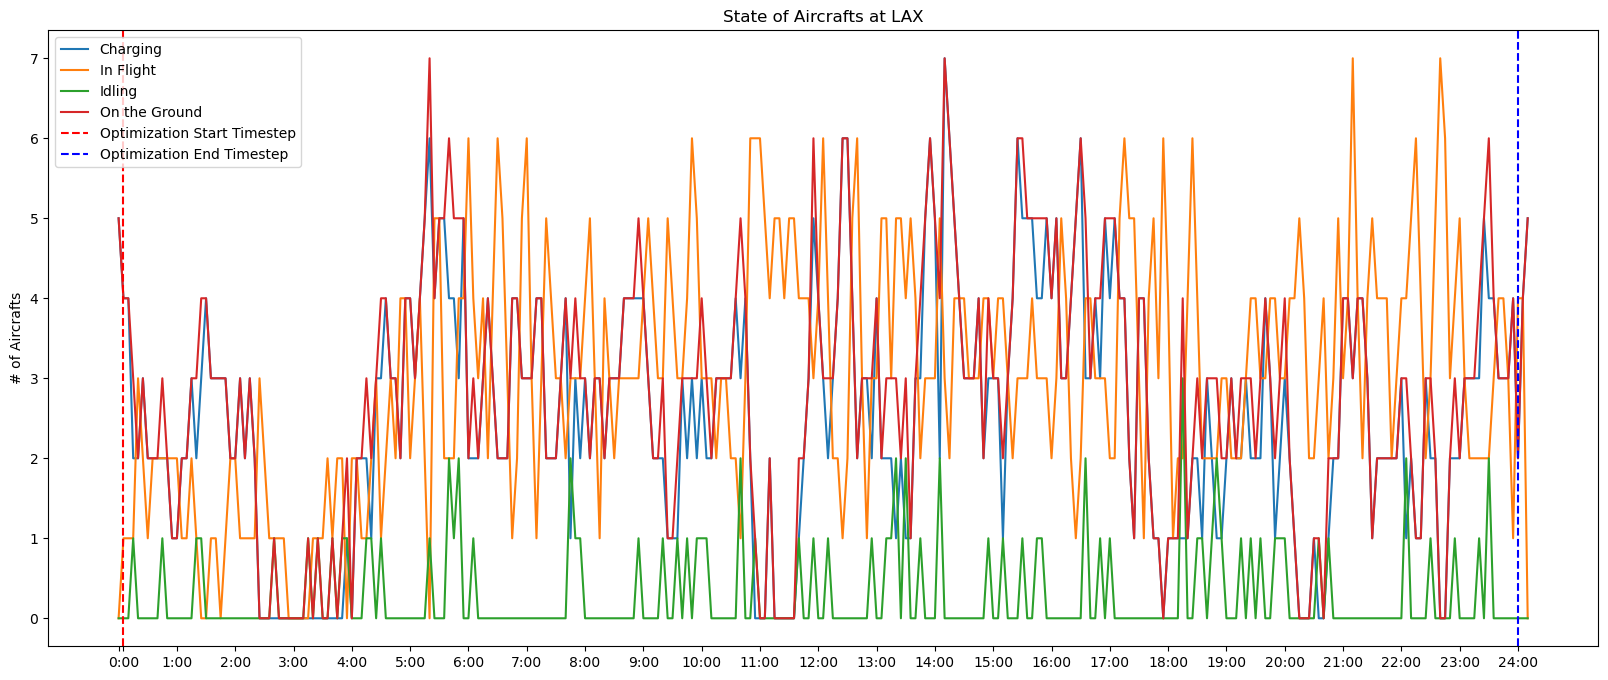

In [52]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(lax_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(lax_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(lax_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((lax_all_c.sum(axis=0)[x0:x1] + lax_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at LAX',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');

In [53]:
print('At t = 0, c =', lax_all_c.sum(axis=0)[x0:x1][0], '; u=', lax_all_u.sum(axis=0)[x0:x1][0], '; n=', lax_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', lax_all_c.sum(axis=0)[x0:x1][286], '; u=', lax_all_u.sum(axis=0)[x0:x1][286], '; n=', lax_all_n.sum(axis=0)[x0:x1][286])

At t = 0, c = 5.0 ; u= 0.0 ; n= 0.0
At t = 290, c = 3.0 ; u= 3.0 ; n= 0.0


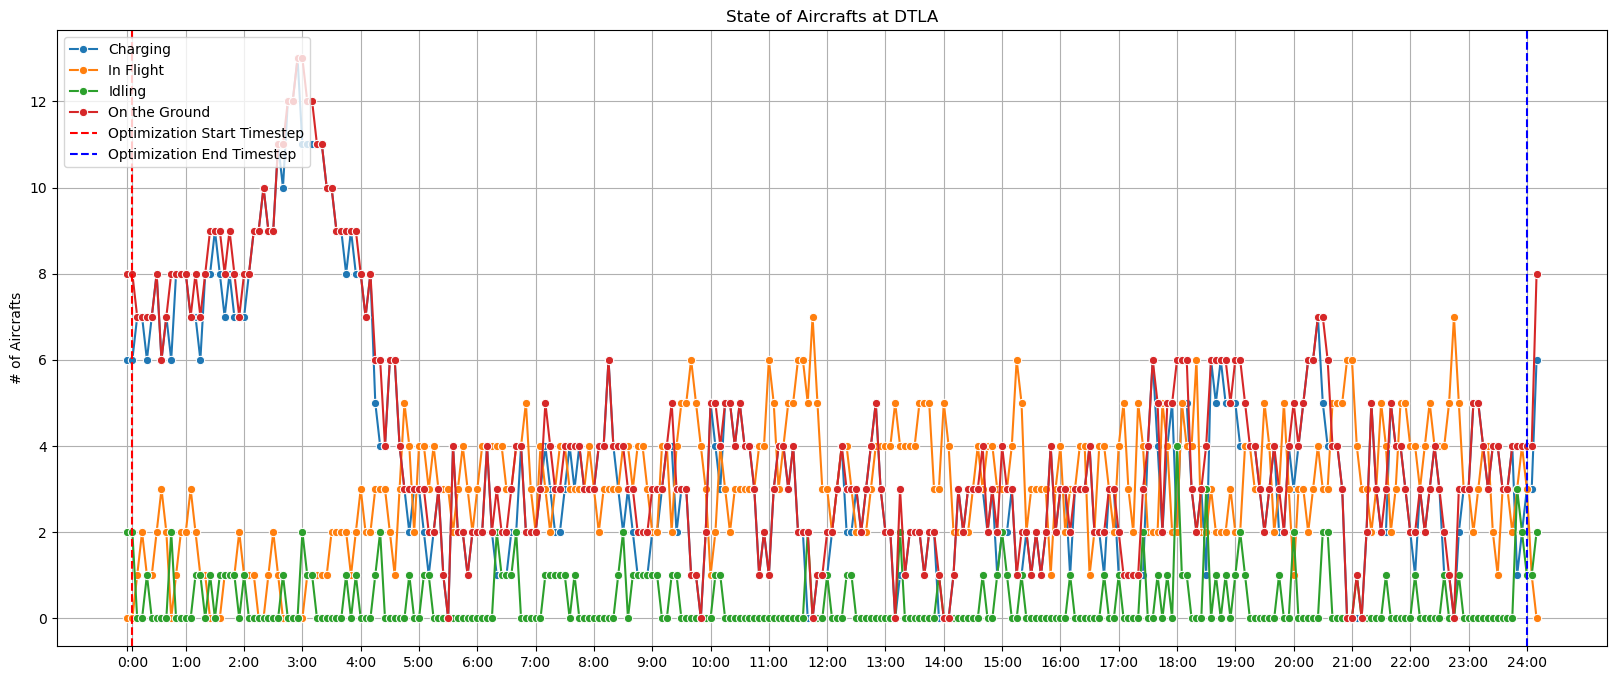

In [54]:
x0 = 0
x1 = 291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(dtla_all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax, marker='o')
sns.lineplot(dtla_all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax, marker='o')
sns.lineplot(dtla_all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax, marker='o')
sns.lineplot((dtla_all_c.sum(axis=0)[x0:x1] + dtla_all_n.sum(axis=0)[x0:x1]), label='On the Ground', ax=ax, marker='o')
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts at DTLA',
       ylabel='# of Aircrafts',
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
plt.grid()

In [55]:
print('At t = 0, c =', dtla_all_c.sum(axis=0)[x0:x1][0], '; u=', dtla_all_u.sum(axis=0)[x0:x1][0], '; n=', dtla_all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', dtla_all_c.sum(axis=0)[x0:x1][290], '; u=', dtla_all_u.sum(axis=0)[x0:x1][290], '; n=', dtla_all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 6.0 ; u= 0.0 ; n= 2.0
At t = 290, c = 6.0 ; u= 0.0 ; n= 2.0


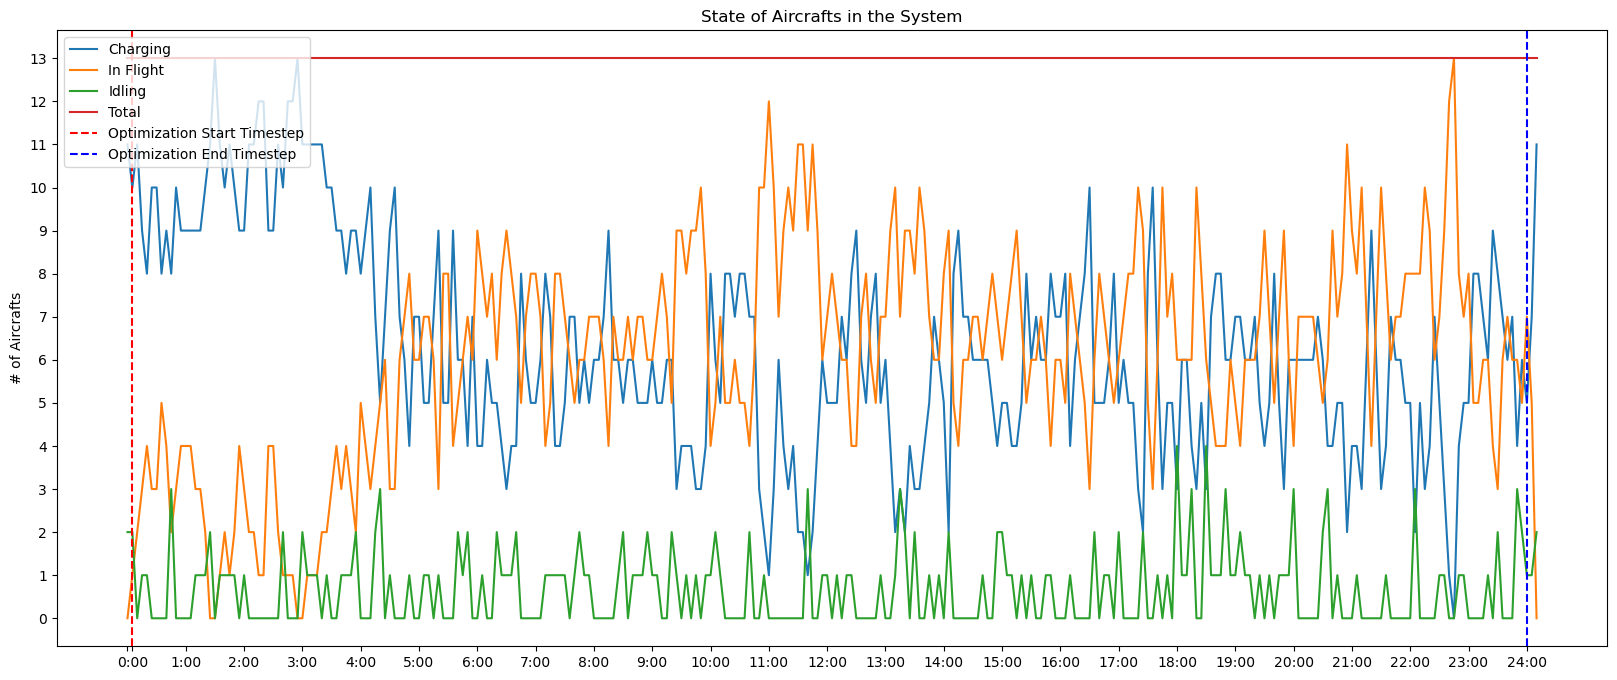

In [56]:
x0=0
x1=291

fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(all_c.sum(axis=0)[x0:x1], label='Charging', ax=ax)
sns.lineplot(all_u.sum(axis=0)[x0:x1], label='In Flight', ax=ax)
sns.lineplot(all_n.sum(axis=0)[x0:x1], label='Idling', ax=ax)
sns.lineplot((all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1]), label='Total', ax=ax)
ax.axvline(x=1, color='red', linestyle='--', label='Optimization Start Timestep')
ax.axvline(x=288, color='blue', linestyle='--', label='Optimization End Timestep')
ax.set(title='State of Aircrafts in the System',
       ylabel='# of Aircrafts',
       yticks=np.arange(0, (all_c.sum(axis=0)[x0:x1] + all_u.sum(axis=0)[x0:x1] + all_n.sum(axis=0)[x0:x1])[0]+1),
       xticks=np.concatenate([np.array([0,1]), np.arange(12,300, 12)]),
       xticklabels=['']+[str(i)+':00' for i in range(0,25)])
plt.legend(loc='upper left');
# plt.xlim([0, 10])

In [14]:
print('At t = 0, c =', all_c.sum(axis=0)[x0:x1][0], '; u=', all_u.sum(axis=0)[x0:x1][0], '; n=', all_n.sum(axis=0)[x0:x1][0])
print('At t = 290, c =', all_c.sum(axis=0)[x0:x1][290], '; u=', all_u.sum(axis=0)[x0:x1][290], '; n=', all_n.sum(axis=0)[x0:x1][290])

At t = 0, c = 4.0 ; u= 0.0 ; n= 7.0
At t = 290, c = 4.0 ; u= 0.0 ; n= 7.0
